# Simulation and optimisation of pressure distribution in a combustion chamber

This exercise is concerned with the simulation and optimisation of pressure distribution within a combustion chamber to ensure efficient fuel combustion and enhance engine performance. The design and optimisation of pressure distribution are crucial for achieving a uniform distribution, and this analysis involves simulating how various burner configurations affect the pressure distribution. The study utilises a two-dimensional model that balances computational efficiency with accuracy, making it applicable to various engineering fields where combustion efficiency is critical.

## Problem formulation

To analyse the pressure distribution within a combustion chamber, a mathematical model is developed based on fundamental principles of fluid dynamics. This formulation encapsulates the effects of burner configurations on pressure distribution and provides a basis for optimising the chamber's design.

### Governing equations

The pressure distribution within the combustion chamber is governed by the Poisson equation, describing pressure variations due to burner sources:

$$
\nabla^2 P(x,y) = -\frac{f(x,y)}{k},
$$

-   $P(x,y)$ is the pressure field at spatial coordinates $(x,y)$ $\left[\text{Pa}\right]$,
-   $f(x,y)$ represents the pressure source function from burners $\left[\text{Pa}/\text{m}^2\right]$,
-   $k$ is a proportionality constant related to fluid properties.

In Cartesian coordinates, the equation expands to:

$$
\frac{\partial^2 P}{\partial x^2} + \frac{\partial^2 P}{\partial y^2} = -\frac{f(x,y)}{k}
$$

#### Initial and boundary conditions

The problem is solved under specific boundary and initial conditions, which influence the overall pressure distribution.

1. **Boundary conditions**

    - Dirichlet condition (fixed pressure at chamber walls):
        $$
        P(x,y) = P_0 \quad \text{for} \quad (x,y) \in \partial \Omega
        $$
    - Neumann condition (zero normal pressure gradient at exits):
        $$
        \frac{\partial P}{\partial n} = 0 \quad \text{at outlet boundaries}
        $$

2. **Initial condition**
    - The pressure is assumed to be **uniform** throughout the chamber before the burners are activated:
        $$
        P(x, y, t=0) = P_{\text{ambient}}
        $$

### Heat source model for burners

The burner heat input is modelled as a Gaussian distribution, representing spatial heat injection:

$$
f(x,y) = \sum_{i=1}^{N} A_i \exp \left( -\frac{(x - x_i)^2 + (y - y_i)^2}{\sigma^2} \right),
$$

where:

-   $(x_i, y_i)$ are the burner locations,
-   $A_i$ is the burner intensity $\left[\text{Pa}/\text{m}^2\right]$ (per semplicità $A_i = 1\ \forall i$),
-   $\sigma$ is the spread parameter, controlling burner heat dissipation.

This formulation assumes each burner contributes additively to the pressure field, with localised effects decaying exponentially away from the burner centre.

### Numerical Solution

#### Finite Difference Method (FDM) discretisation

Using a structured grid with spacing $h$, the second derivatives in the Poisson equation are approximated by:

$$
\frac{\partial^2 P}{\partial x^2} \approx \frac{P_{i+1,j} - 2 P_{i,j} + P_{i-1,j}}{h^2} , \quad \frac{\partial^2 P}{\partial y^2} \approx \frac{P_{i,j+1} - 2 P_{i,j} + P_{i,j-1}}{h^2} .
$$

Finally, rearranging the equation to solve for $P_{i,j}$ gives the iterative update formula:

$$
P_{i,j}^{(n+1)} = \frac{P_{i+1,j}^{(n)} + P_{i-1,j}^{(n)} + P_{i,j+1}^{(n)} + P_{i,j-1}^{(n)} - h^2 f_{i,j} / k}{4}.
$$

#### Iterative solvers and convergence criteria

-   Gauss-Seidel method: Solves iteratively, updating grid points in place.
-   Successive over-relaxation (SOR): Accelerates convergence using a relaxation parameter $\omega$.
-   Multigrid methods: Applied for large-scale simulations to enhance computational efficiency.

The stopping criterion is based on the residual error:

$$
\max \left| P^{(n+1)} - P^{(n)} \right| < \epsilon.
$$

where $\epsilon$ is a user-defined convergence threshold.

### Optimisation of burner configuration

#### Objective function: pressure uniformity

To achieve an optimal pressure distribution, we define a cost function based on pressure variance:

$$
J = \sum_{i,j} (P_{i,j} - \overline{P})^2.
$$

where $\overline{P}$ is the mean pressure value across the combustion chamber. This ensures the pressure values across the chamber are as close as possible to each other.

#### Optimisation technique: gradient-based optimisation

Both the burner positions $(x_i, y_i)$ and their intensities $A_i$ are adjusted iteratively to minimise the cost function:

$$
x_i^{(n+1)} = x_i^{(n)} - \alpha \frac{\partial J}{\partial x_i}, \quad y_i^{(n+1)} = y_i^{(n)} - \alpha \frac{\partial J}{\partial y_i}, \quad A_i^{(n+1)} = A_i^{(n)} - \alpha \frac{\partial J}{\partial A_i}.
$$

where $\alpha$ is the learning rate. The optimisation process follows a gradient-based approach, updating parameters based on the sensitivity of the cost function to changes in burner positions and intensities.

### Model assumptions

1. The combustion chamber is modelled as a two-dimensional system, assuming negligible variations along the third dimension.  
2. The pressure distribution is assumed to reach a steady-state, meaning time-dependent effects are not considered.  
3. The combustion chamber is treated as a uniform medium with no spatial variations in material properties.  
4. The gas within the chamber follows the assumptions of an ideal gas, where compressibility effects are not explicitly considered.  
5. The chamber walls are assumed to have fixed boundary conditions, ensuring a well-posed numerical solution.  
6. The heat sources (burners) are modelled using a Gaussian distribution to represent localised pressure contributions.  


## Implementation

The implementation presented herein pertains to solving the pressure distribution problem within a combustion chamber. The solution employs the Finite Difference Method (FDM) to discretise the governing equations. The solution is iteratively computed across the defined grid, adhering to the specified boundary and initial conditions.

### Parameter definition and initialisation

First, the domain parameters, boundary conditions, burner configuration, and initial conditions are defined as follows.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Ensure interactive plots in Jupyter Notebook
plt.close("all")

# Seed for reproducibility
np.random.seed(1)

# Domain parameters
Lx, Ly = 1.0, 1.0  # Dimensions of the combustion chamber (m)
Nx, Ny = 30, 30  # Number of grid points in x and y directions
h = Lx / (Nx - 1)  # Grid spacing (assumed same in x and y)

# Pressure parameters
P0 = 100.0  # Fixed pressure at chamber walls (Pa)
P_ambient = 1.0  # Initial uniform pressure (Pa)

# Burner parameters
num_burners = 3  # Number of burners
sigma = 0.08  # Spread parameter for the Gaussian burner model
k_const = 1.0  # Proportionality constant in the Poisson equation

# Generate initial burner configuration: (x, y) for each burner
burners_init = [
    (np.random.uniform(2 * h, Lx - 2 * h), np.random.uniform(2 * h, Ly - 2 * h))
    for _ in range(num_burners)
]

# Create spatial grid for evaluation
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)


### Burner source model

The burner pressure input is modelled as a Gaussian distribution representing localised pressure injection. The contributions from all burners are summed, and the model is incorporated into the Poisson equation.

In [2]:
def calculate_burner_source(X, Y, burners, sigma=sigma, k_const=k_const):
    """
    Calculate the heat source term for the Poisson equation based on Gaussian burners.

    Parameters
    ----------
    X : np.ndarray
        Array of x-coordinates.
    Y : np.ndarray
        Array of y-coordinates.
    burners : list
        List of burners, where each burner is a tuple (x, y).
    sigma : float
        Spread parameter for the Gaussian burner model.
    k_const : float
        Proportionality constant in the Poisson equation.

    Returns
    -------
    source : np.ndarray
        Heat source term for the Poisson equation.
    """
    # Initialise heat source term
    f = np.zeros_like(X)

    # Add contribution from each burner
    for xb, yb in burners:
        f += np.exp(-((X - xb) ** 2 + (Y - yb) ** 2) / sigma**2)

    # Negative sign as per the Poisson equation
    source = -f / k_const

    return source


### Boundary conditions

The specified boundary conditions are applied to the pressure field to ensure accurate simulation of the chamber's physical constraints.

In [3]:
def apply_boundary_conditions(P, P0):
    """
    Apply the specified boundary conditions to the pressure field.

    Parameters
    ----------
    P : np.ndarray
        Pressure field.
    P0 : float
        Pressure value at the boundaries.

    Returns
    -------
    P : np.ndarray
        Pressure field with boundary conditions applied.
    """
    P[0, :] = P0  # Left boundary
    P[-1, :] = P0  # Right boundary
    P[:, 0] = P0  # Bottom boundary
    P[:, -1] = P0  # Top boundary

    return P


### Pressure update

The pressure field is updated using the finite difference discretisation of the Poisson equation.

In [4]:
def update_pressure(P, f, h, k_const=k_const):
    """
    Update the pressure field using the Poisson equation.

    Parameters
    ----------
    P : np.ndarray
        Pressure field at the current time step.
    f : np.ndarray
        Heat source term for the Poisson equation.
    h : float
        Grid spacing.
    k_const : float
        Proportionality constant in the Poisson equation.

    Returns
    -------
    P_new : np.ndarray
        Updated pressure field.
    """
    # Update pressure field using the Poisson equation
    P_new = (
        np.roll(P, 1, axis=0)
        + np.roll(P, -1, axis=0)
        + np.roll(P, 1, axis=1)
        + np.roll(P, -1, axis=1)
        - h**2 * f / k_const
    ) / 4.0

    return P_new


### Iterative solver

A Jacobi iterative method is used to solve the Poisson equation until the solution converges. The convergence criterion is based on the maximum absolute difference between successive iterations.

In [5]:
def solve_poisson(P, f, h, tol=1e-6, max_iter=10000):
    """
    Solve the Poisson equation for pressure using the Jacobi iterative method.

    Parameters
    ----------
    P : np.ndarray
        Initial guess for the pressure field.
    f : np.ndarray
        Heat source term for the Poisson equation.
    h : float
        Grid spacing.
    tol : float, optional
        Error tolerance for convergence. The default is 1e-5.
    max_iter : int, optional
        Maximum number of iterations. The default is 10000.

    Returns
    -------
    P : np.ndarray
        Pressure field at the converged state.
    """
    for it in range(max_iter):
        # Copy the pressure field and update it
        P_old = P.copy()

        # Update the pressure field
        P = update_pressure(P, f, h)
        P = apply_boundary_conditions(P, P0)

        # Check for convergence
        if np.linalg.norm(P - P_old) < tol:
            break

    return P


## Results

### Complete simulation

The simulation is conducted iteratively to observe the pressure distribution within the combustion chamber until the steady-state is reached. At each iteration, the pressure field is updated based on the discretised Poisson equation and boundary conditions. 

In [ ]:
def solve_pressure_distribution(burners):
    """
    Compute the pressure distribution by solving the Poisson equation for a given burner configuration.

    Parameters
    ----------
    burners : list
        List of burners, where each burner is a tuple (x, y).

    Returns
    -------
    P : np.ndarray
        Pressure distribution in the combustion chamber.
    """
    # Calculate the source term for the Poisson equation
    f = calculate_burner_source(X, Y, burners)

    # Initialise the pressure field
    P = np.full((Nx, Ny), P_ambient)

    # Solve the Poisson equation to obtain the pressure field
    P = solve_poisson(P, f, h)

    return P

### Optimisation of burner configuration

Since `scipy.optimize.minimize` works with a 1D array, the helper functions convert the $(x,y)$ tuples into a flat array before optimisation and restore them afterward.

In [7]:
def flatten_burners(burners):
    """Convert a structured array of burners into a flat array."""
    return np.array(burners).flatten()


def unflatten_burners(flat_burners, num_burners):
    """Convert flat array of burners to structured array."""
    return flat_burners.reshape(num_burners, 2).tolist()


#### Objective function: pressure uniformity

The cost function is defined to minimise the variance of the pressure field in order to achieve a pressure that is as uniform as possible across the combustion chamber.

In [8]:
def objective_function(burners):
    """
    Compute source term and solve the Poisson equation for a given burner configuration.

    Parameters
    ----------
    burners : np.ndarray
        Array of burner parameters (x, y).

    Returns
    -------
    cost : float
        Cost function to be minimised.
    """
    # Parse the burner configuration using the helper function
    if burners.ndim == 1:
        burners = unflatten_burners(burners, len(burners) // 2)

    P = solve_pressure_distribution(burners)

    # Cost function: minimise the variance of the pressure field to achieve uniformity
    cost = np.sum((P - np.mean(P)) ** 2)

    return cost

#### Initial pressure distribution

The initial pressure distribution is obtained using a randomly generated burner configuration. Pressure variations are influenced by the arbitrary placement and intensities of the burners, leading to non-uniform regions across the combustion chamber. Higher pressure zones appear near the initial burner positions, with gradients extending towards the boundaries.

In [9]:
# Print initial burner configuration
print("Initial burner configuration:")
for i, (x, y) in enumerate(burners_init):
    print(f"- Burner {i + 1}: x = {x:.4f}, y = {y:.4f}")

# Solve the Poisson equation for the initial (random) burner configuration
P = solve_pressure_distribution(burners_init)

Initial burner configuration:
- Burner 1: x = 0.4285, y = 0.6899
- Burner 2: x = 0.0691, y = 0.3296
- Burner 3: x = 0.1955, y = 0.1486


#### Optimised pressure distribution

The optimised pressure distribution results from adjusting burner locations and intensities to minimise pressure variance. This configuration achieves a more uniform pressure field, reducing localised high-pressure regions and ensuring a smoother gradient across the chamber.

In [10]:
# Convert to flat format for optimisation
initial_condition = flatten_burners(burners_init)

# Define bounds: (x, y) for each burner
bounds = ([(2 * h, Lx - 2 * h), (2 * h, Ly - 2 * h)]) * num_burners

# List to store cost values
cost_values = []


# Callback function to store cost values
def callback(xk):
    cost_values.append(objective_function(xk))


# Run the gradient-based optimisation with callback
result = minimize(
    objective_function,
    initial_condition,
    bounds=bounds,
    method="L-BFGS-B",
    callback=callback,
)

print(result)

# Extract the optimised burner configuration
burners_opt = unflatten_burners(result.x, num_burners)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.00013717958402443493
        x: [ 9.310e-01  9.310e-01  6.897e-02  9.310e-01  6.897e-02
             6.897e-02]
      nit: 7
      jac: [-7.654e-04 -7.584e-04  8.138e-04 -8.138e-04  7.583e-04
             7.654e-04]
     nfev: 126
     njev: 18
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [11]:
# Print the optimised burner configuration
print("Optimised burner configuration:")
for i, (x, y) in enumerate(burners_opt):
    print(f"- Burner {i + 1}: x = {x:.4f}, y = {y:.4f}")

# Solve the Poisson equation for the initial (random) burner configuration
P_opt = solve_pressure_distribution(burners_opt)

Optimised burner configuration:
- Burner 1: x = 0.9310, y = 0.9310
- Burner 2: x = 0.0690, y = 0.9310
- Burner 3: x = 0.0690, y = 0.0690


### Visualisation of results


#### 1. Compare the initial and optimised pressure distributions

This function generates two contour plots: one for the initial pressure distribution and another for the optimised pressure distribution. The function also overlays burner locations to show their positions before and after optimisation.

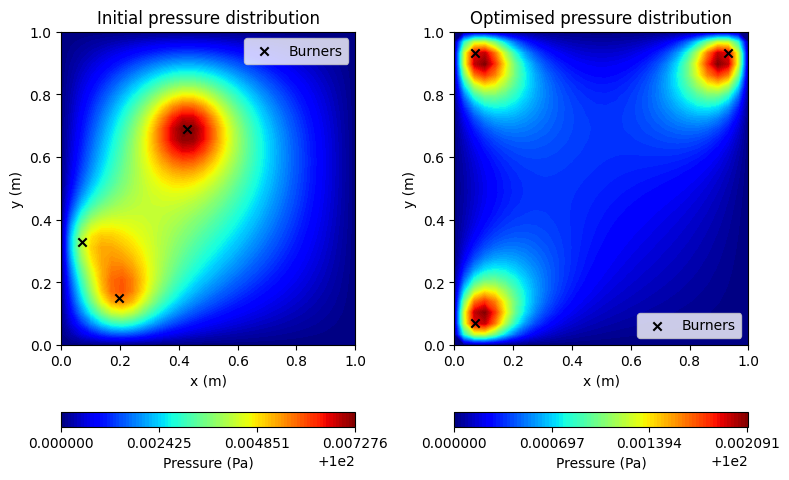

In [12]:
def compare_pressure_distributions(
    X, Y, P_initial, P_optimised, burners_init, burners_opt
):
    """
    Plot the initial and optimised pressure distributions.

    Parameters
    ----------
    X : np.ndarray
        Array of x-coordinates.
    Y : np.ndarray
        Array of y-coordinates.
    P_initial : np.ndarray
        Initial pressure distribution.
    P_optimised : np.ndarray
        Optimised pressure distribution.
    burners_init : list
        Initial burner configuration.
    burners_opt : list
        Optimised burner configuration.

    Returns
    -------
    None
    """
    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))

    # Convert to numpy arrays for plotting
    burners_init = np.array(burners_init)
    burners_opt = np.array(burners_opt)

    # Initial pressure distribution
    ax1 = axes[0]
    contour = ax1.contourf(X, Y, P_initial, levels=100, cmap="jet")
    fig.colorbar(
        contour,
        ax=ax1,
        label="Pressure (Pa)",
        location="bottom",
        ticks=np.linspace(P_initial.min(), P_initial.max(), num=4),
    )

    # Plot the initial burner locations
    ax1.scatter(
        burners_init[:, 0], burners_init[:, 1], color="k", marker="x", label="Burners"
    )

    # Plot settings
    ax1.set_title("Initial pressure distribution")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    ax1.legend()

    # Optimised pressure distribution
    ax2 = axes[1]
    contour = ax2.contourf(X, Y, P_optimised, levels=100, cmap="jet")
    fig.colorbar(
        contour,
        ax=ax2,
        label="Pressure (Pa)",
        location="bottom",
        ticks=np.linspace(P_optimised.min(), P_optimised.max(), num=4),
    )

    # Plot the optimised burner locations
    ax2.scatter(
        burners_opt[:, 0], burners_opt[:, 1], color="k", marker="x", label="Burners"
    )

    # Plot settings
    ax2.set_title("Optimised pressure distribution")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    ax2.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Plot the initial and optimised pressure distributions
compare_pressure_distributions(X, Y, P, P_opt, burners_init, burners_opt)

#### 2. Tracking cost function convergence

This function plots the cost function (variance of pressure) over iterations to illustrate the optimisation's progress.

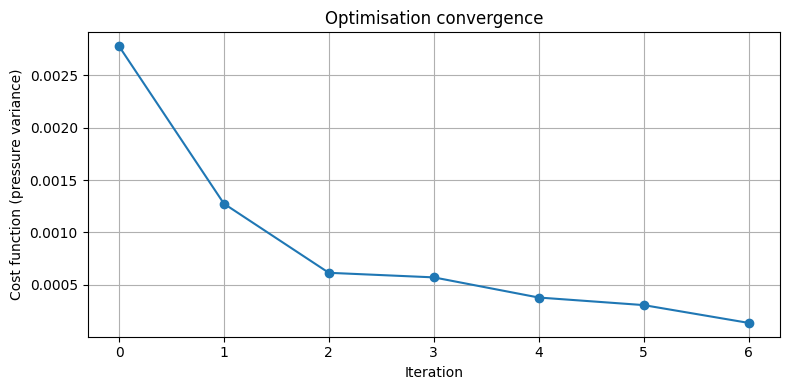

In [13]:
def plot_cost_function(cost_values):
    """
    Plot the cost function reduction over iterations.

    Parameters:
    cost_values : list or np.ndarray
        Sequence of cost values recorded during optimisation.

    Returns
    -------
    None
    """
    # Create figure and axes
    plt.figure(figsize=(8, 4))

    # Plot the cost function reduction over iterations
    plt.plot(cost_values, marker="o", linestyle="-")

    # Plot settings
    plt.xlabel("Iteration")
    plt.ylabel("Cost function (pressure variance)")
    plt.title("Optimisation convergence")
    plt.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Plot the cost function reduction over iterations
plot_cost_function(cost_values)

#### 3. Visualisation of burner position changes

This function uses a quiver plot to display how burner positions have shifted from their initial placement to their optimised locations.

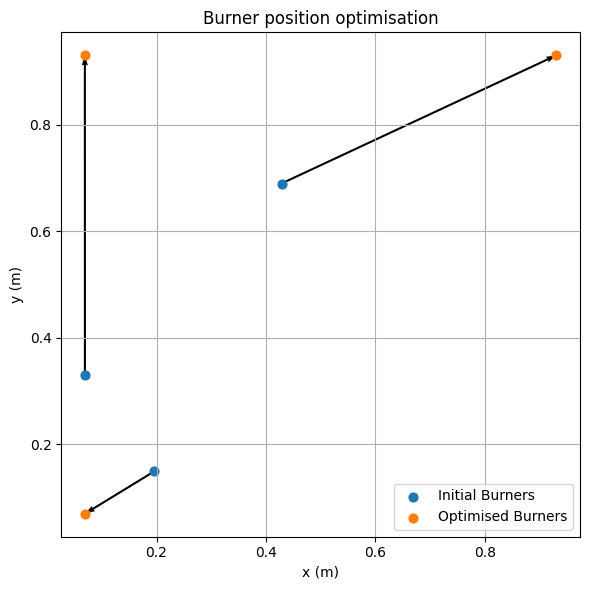

In [14]:
def plot_burner_positions(burners_init, burners_opt):
    """
    Show how burner positions changed using a quiver plot.

    Parameters:
    burners_init : list of tuples
        Initial burner positions (x, y).
    burners_opt : list of tuples
        Optimised burner positions (x, y).

    Returns
    -------
    None
    """
    # Convert to numpy arrays for plotting
    burners_init = np.array(burners_init)
    burners_opt = np.array(burners_opt)

    # Create figure and axes
    plt.figure(figsize=(6, 6))

    # Visualise the change in burner positions
    plt.quiver(
        burners_init[:, 0],
        burners_init[:, 1],
        burners_opt[:, 0] - burners_init[:, 0],
        burners_opt[:, 1] - burners_init[:, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="k",
        width=0.004,
    )

    # Plot the initial and optimised burner positions
    plt.scatter(
        burners_init[:, 0],
        burners_init[:, 1],
        s=40,
        label="Initial Burners",
    )
    plt.scatter(
        burners_opt[:, 0],
        burners_opt[:, 1],
        s=40,
        label="Optimised Burners",
    )

    # Plot settings
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Burner position optimisation")
    plt.legend()
    plt.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Plot the change in burner positions
plot_burner_positions(burners_init, burners_opt)

#### 4. Comparing pressure distributions with a histogram

This function generates histograms for the initial and optimised pressure distributions to assess how the optimisation alters pressure variability.

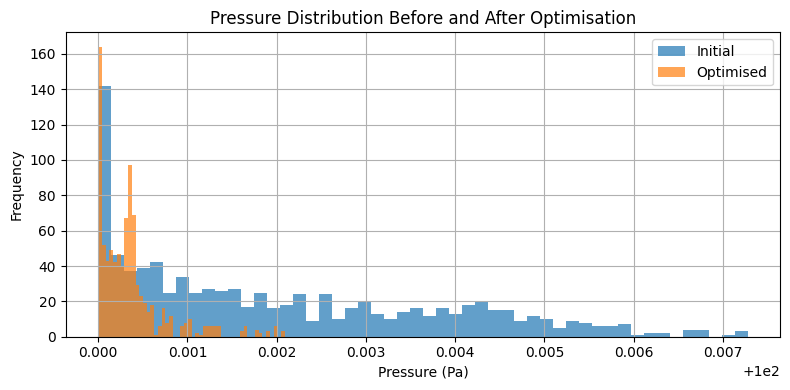

In [15]:
def compare_pressure_histograms(P_initial, P_optimised):
    """
    Compare pressure distributions before and after optimisation using histograms.

    Parameters:
    P_initial : np.ndarray
        Initial pressure field.
    P_optimised : np.ndarray
        Optimised pressure field.

    Returns
    -------
    None
    """
    # Create figure and axes
    plt.figure(figsize=(8, 4))

    # Plot histograms of pressure distributions
    plt.hist(P_initial.flatten(), bins=50, alpha=0.7, label="Initial")
    plt.hist(P_optimised.flatten(), bins=50, alpha=0.7, label="Optimised")

    # Plot settings
    plt.xlabel("Pressure (Pa)")
    plt.ylabel("Frequency")
    plt.title("Pressure Distribution Before and After Optimisation")
    plt.legend()
    plt.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Plot histograms of pressure distributions
compare_pressure_histograms(P, P_opt)

#### 5. Compare initial and optimised pressure using Laplacian and streamlines

This function visualises the Laplacian of the pressure field and the corresponding streamlines for both the initial and optimised pressure distributions. The Laplacian highlights regions of rapid pressure change, while streamlines provide insight into the pressure gradient flow.

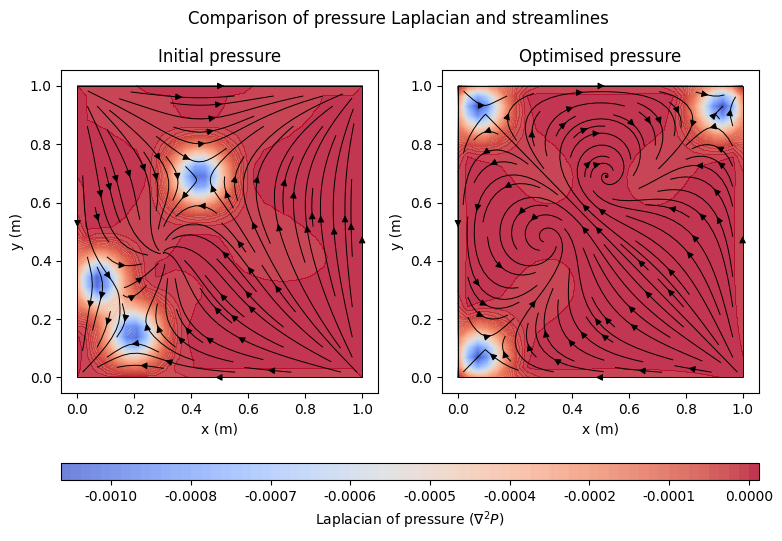

In [16]:
def compare_laplacian_and_streamlines(X, Y, P_initial, P_optimised):
    """
    Visualizes and compares the Laplacian of pressure for the initial and optimised cases.
    Overlays streamlines to show pressure flow.

    Parameters
    ----------
    X : np.ndarray
        Grid of x-coordinates.
    Y : np.ndarray
        Grid of y-coordinates.
    P_initial : np.ndarray
        Initial pressure field.
    P_optimised : np.ndarray
        Optimised pressure field.

    Returns
    -------
    None
    """

    # Compute Laplacian of pressure
    def compute_laplacian(P):
        d2P_dx2 = np.gradient(np.gradient(P, axis=0), axis=0)
        d2P_dy2 = np.gradient(np.gradient(P, axis=1), axis=1)
        return d2P_dx2 + d2P_dy2

    laplacian_P_initial = compute_laplacian(P_initial)
    laplacian_P_optimised = compute_laplacian(P_optimised)

    # Compute pressure gradient for streamlines
    dP_initial_dx, dP_initial_dy = np.gradient(P_initial)
    dP_optimised_dx, dP_optimised_dy = np.gradient(P_optimised)

    # Set a consistent color scale range
    vmin = min(laplacian_P_initial.min(), laplacian_P_optimised.min())
    vmax = max(laplacian_P_initial.max(), laplacian_P_optimised.max())

    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(9, 6))

    # Plot initial pressure Laplacian
    ax = axes[0]
    cf = ax.contourf(
        X,
        Y,
        laplacian_P_initial,
        levels=100,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
    )
    ax.streamplot(X, Y, -dP_initial_dx, -dP_initial_dy, color="k", linewidth=0.7)

    # Plot settings
    ax.set_title("Initial pressure")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    # Plot optimised pressure Laplacian
    ax = axes[1]
    ax.contourf(
        X,
        Y,
        laplacian_P_optimised,
        levels=100,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
    )
    ax.streamplot(X, Y, -dP_optimised_dx, -dP_optimised_dy, color="k", linewidth=0.7)

    # Plot settings
    ax.set_title("Optimised pressure")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    # Add a title for the whole figure
    fig.suptitle("Comparison of pressure Laplacian and streamlines")

    # Create a single colorbar below both plots
    cbar = fig.colorbar(
        cf,
        ax=axes,
        location="bottom",
        aspect=40,
        format="%.4f",
    )
    cbar.set_label(r"Laplacian of pressure ($\nabla^2 P$)")

    # Show the plots
    plt.show()


# Compare Laplacian of pressure and streamlines
compare_laplacian_and_streamlines(X, Y, P, P_opt)